In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
import pathlib
import zipfile

2024-11-29 16:25:42.220142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 16:25:42.614320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 16:25:42.792516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 16:25:43.605004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
noted_path = os.getcwd()
noted_path

'/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project'

### **Helper Functions**

In [41]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

**<span style="color:#180842; font-size:26px">
Second Train/Validation Data Set
</span>** <br>

In [3]:
#https://www.dropbox.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0
test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"

In [4]:
data_dir_two = tf.keras.utils.get_file('test_google_images_landslide_three.zip', origin=test_dataset_url, extract=True)
data_dir_two = pathlib.Path(data_dir_two).with_suffix('')

In [5]:
## Review folders in incoming data / classes
folders_two = [folder for folder in data_dir_two.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders_two:
    print(folder.name)

Folders in the test directory:
Google_Earth_Images


In [11]:
# Drill into each subdirectory and list files
for folder in folders_two:
    print(f"\nContents of folder '{folder.name}':")
    for subitem in folder.iterdir():
        if subitem.is_file():
            print(f"  File: {subitem.name}")
        elif subitem.is_dir():
            print(f"  Subfolder: {subitem.name}")
            count = len(list(subitem.glob('*.jpg')))
            print(f"{subitem.name}: {count} .jpg images")


Contents of folder 'Google_Earth_Images':
  Subfolder: landslides
landslides: 47 .jpg images
  Subfolder: non-landslides
non-landslides: 67 .jpg images
  File: .DS_Store


In [12]:
print(data_dir_two)

/home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted


In [16]:
## Update Directory
data_dir_two_alt_path = '/home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images'
print(data_dir_two_alt_path)

/home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images


**<span style="color:#180842; font-size:26px">
Set Training/Validation Data & Split
</span>** <br>

In [46]:
## Set Batch and Image size. 
batch_size = 32
img_height = 300
img_width = 300

#### Create Training / Validation Sets

In [47]:
## Set Training Set image set. 
train_dataset_two = tf.keras.utils.image_dataset_from_directory(
  data_dir_two_alt_path,
  validation_split=0.4,
  subset="training",
  seed=904,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 114 files belonging to 2 classes.
Using 69 files for training.


In [48]:
## Setup Valiation set.
valid_dataset_two = tf.keras.utils.image_dataset_from_directory(
  data_dir_two_alt_path,
  validation_split=0.60,
  subset="validation",
  seed=904,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 114 files belonging to 2 classes.
Using 68 files for validation.


In [49]:
# Count the total samples in training and validation sets
train_count = sum(1 for _ in train_dataset_two.unbatch())
valid_count = sum(1 for _ in valid_dataset_two.unbatch())

# Initialize class counters
train_class_counts = {}
valid_class_counts = {}

# Function to count samples per class
def count_classes(dataset, class_counts):
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Count samples in training and validation datasets
count_classes(train_dataset_two, train_class_counts)
count_classes(valid_dataset_two, valid_class_counts)

# Display counts
print(f"Training set size: {train_count}")
print(f"Validation set size: {valid_count}")
print("\nClass distribution in Training set:")
for class_label, count in sorted(train_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

print("\nClass distribution in Validation set:")
for class_label, count in sorted(valid_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

Training set size: 69
Validation set size: 68

Class distribution in Training set:
  Class 0: 27 samples
  Class 1: 42 samples

Class distribution in Validation set:
  Class 0: 30 samples
  Class 1: 38 samples


## Buffering/Shuffle

In [50]:
## Data Performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_two = train_dataset_two.cache().shuffle(3200).prefetch(buffer_size=AUTOTUNE)
valid_dataset_two = valid_dataset_two.cache().prefetch(buffer_size=AUTOTUNE)

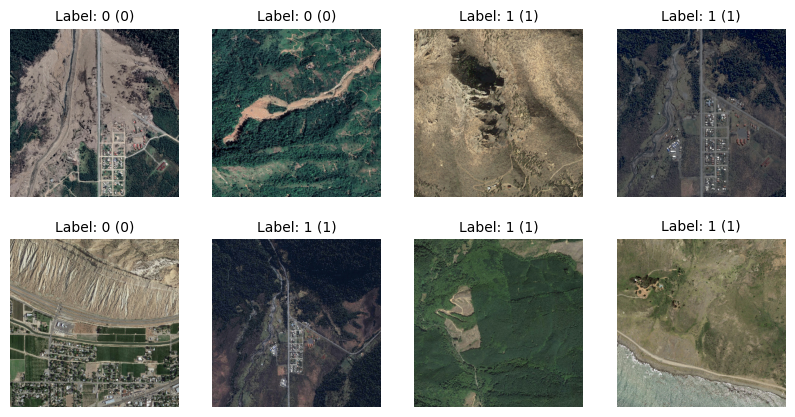

In [51]:
## Checking Images and Labels:
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(8):  # Display first 6 samples
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

<hr style="border:8px solid #301b66">

### **Class Weights for use during Model Fit**
- Added code to create Class Weights (class_weight=class_weight,) that you may use during the Model Fit process. 
- https://keras.io/examples/structured_data/imbalanced_classification/

In [52]:
# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in valid_dataset_two])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
class_weights_dict_goog = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict_goog)

Class weights: {0: 1.1333333333333333, 1: 0.8947368421052632}


2024-11-29 16:52:20.297550: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Load Saved Keras Model and Further Train
</span>** <br>


In [53]:
reconstruct_path = (f'{noted_path}/ENB3_One_hh.keras')
reconstruct_path

'/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project/ENB3_One_hh.keras'

In [54]:
reconst_ENB3 = keras.models.load_model(reconstruct_path)

**Check to see which layers are open**

In [55]:
# reconst_ENB3.summary(show_trainable=True)

**Fine-Tuning Helper**

In [56]:
## Set Layers to Open
layer_open = 0
## Update Model
def unfreeze_model(model, layer_num):   
    # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
    for layer in model.layers[-layer_num:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  
        # optimizer=optimizer, loss="binary_crossentropy", metrics=metrics_detail )  ## Rather than 'accuracy'

In [57]:
unfreeze_model(reconst_ENB3, layer_open)

epochs = 10  # @param {type: "slider", min:8, max:80}
ENB3_2nd_ENB3_hist = reconst_ENB3.fit(valid_dataset_two, epochs=epochs, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

Epoch 1/10


E0000 00:00:1732917192.444050  654964 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732917192.562611  654964 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732917193.185239  654964 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732917193.299243  654964 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732917193.595637  654964 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5547 - loss: 1.3096 

E0000 00:00:1732917225.840507  654966 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732917225.952196  654966 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732917226.480661  654966 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732917226.590766  654966 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732917226.938736  654966 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

3/3 ━━━━━━━━━━━━━━━━━━━━ 107s 22s/step - accuracy: 0.5715 - loss: 1.2880 - val_accuracy: 0.6765 - val_loss: 0.8312
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5607 - loss: 1.0695 - val_accuracy: 0.7206 - val_loss: 0.6993
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5793 - loss: 1.0564 - val_accuracy: 0.7206 - val_loss: 0.5917
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7231 - loss: 0.8136 - val_accuracy: 0.7500 - val_loss: 0.5225
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7080 - loss: 0.7498 - val_accuracy: 0.7500 - val_loss: 0.4757
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7920 - loss: 0.5815 - val_accuracy: 0.7941 - val_loss: 0.4364
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8224 - loss: 0.3863 - val_accuracy: 0.8088 - val_loss: 0.4019
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8068 - loss: 0.4829 - val_accuracy: 0.8235 - val_loss: 0.3757
Epoch 9/1

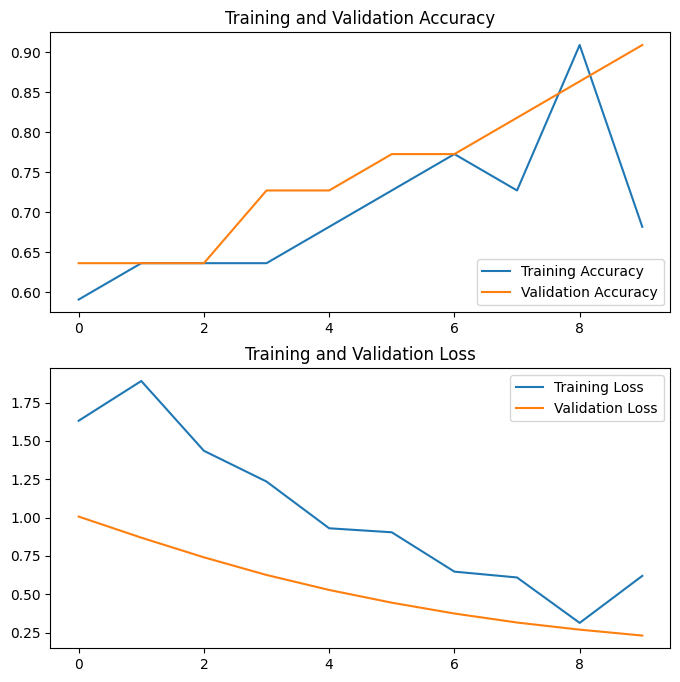

In [58]:
## Plot results
visualize_model_results(ENB3_hist_fine)